In [494]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import datetime as dt
from datetime import datetime, timedelta
import json
from dotenv import load_dotenv

In [495]:
new_weather_data_df = pd.read_csv('Resources/daily_weather_2000_2020.csv')

In [496]:
merged_movies_weather = pd.read_csv('Resources/merged_movies_weather.csv')

In [497]:
merged_movies_weather

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,"$9,845.14","$69,624.34","$53,295.13",...,38.049091,58.111667,46.157083,haze,light rain,overcast clouds,few clouds,overcast clouds,scattered clouds,broken clouds
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,"$51,298.18","$362,778.20","$277,694.70",...,59.534792,91.475833,64.324167,broken clouds,broken clouds,sky is clear,thunderstorm,mist,few clouds,sky is clear
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,"$32,742.17","$231,551.03","$177,244.65",...,44.876250,72.545833,38.504583,light rain and snow,broken clouds,sky is clear,scattered clouds,overcast clouds,few clouds,broken clouds
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,"$6,572.08","$46,477.40","$35,576.91",...,49.385833,62.507917,37.777500,scattered clouds,few clouds,sky is clear,scattered clouds,sky is clear,sky is clear,light rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Whiteout,10275638,Action,Kate Beckinsale,Gabriel Macht,R,2009-09-11,"$4,145.51","$29,316.82","$22,441.06",...,61.115714,93.123750,63.281667,few clouds,light rain,sky is clear,moderate rain,broken clouds,scattered clouds,broken clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
441,Wind River,33800859,Crime,Kelsey Asbille,Jeremy Renner,R,2017-08-03,"$13,636.30","$96,435.25","$73,817.99",...,76.408333,90.094583,72.792500,broken clouds,light rain,sky is clear,broken clouds,moderate rain,broken clouds,sky is clear
442,Young Adam,767373,Crime,Ewan McGregor,Tilda Swinton,NC-17,2003-03-19,$309.53,"$2,188.97","$1,675.58",...,38.885714,58.583333,45.833750,overcast clouds,sky is clear,sky is clear,sky is clear,overcast clouds,scattered clouds,scattered clouds


In [498]:
rename_clean_movies_cities_df = merged_movies_weather.rename(columns={'Release Date':'Date', 'Miami Revenue ($)':'Miami',	'Chicago Revenue ($)':'Chicago',	'Houston Revenue ($)':'Houston',	'Phoenix Revenue ($)':'Phoenix',	'Los Angeles Revenue ($)':'Los Angeles',	'New York Revenue ($)':'New York',	'Seattle Revenue ($)':'Seattle'})
rename_clean_movies_cities_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Date,Miami,Chicago,Houston,...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,"$9,845.14","$69,624.34","$53,295.13",...,38.049091,58.111667,46.157083,haze,light rain,overcast clouds,few clouds,overcast clouds,scattered clouds,broken clouds
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,"$51,298.18","$362,778.20","$277,694.70",...,59.534792,91.475833,64.324167,broken clouds,broken clouds,sky is clear,thunderstorm,mist,few clouds,sky is clear
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,"$32,742.17","$231,551.03","$177,244.65",...,44.876250,72.545833,38.504583,light rain and snow,broken clouds,sky is clear,scattered clouds,overcast clouds,few clouds,broken clouds
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,"$6,572.08","$46,477.40","$35,576.91",...,49.385833,62.507917,37.777500,scattered clouds,few clouds,sky is clear,scattered clouds,sky is clear,sky is clear,light rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Whiteout,10275638,Action,Kate Beckinsale,Gabriel Macht,R,2009-09-11,"$4,145.51","$29,316.82","$22,441.06",...,61.115714,93.123750,63.281667,few clouds,light rain,sky is clear,moderate rain,broken clouds,scattered clouds,broken clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
441,Wind River,33800859,Crime,Kelsey Asbille,Jeremy Renner,R,2017-08-03,"$13,636.30","$96,435.25","$73,817.99",...,76.408333,90.094583,72.792500,broken clouds,light rain,sky is clear,broken clouds,moderate rain,broken clouds,sky is clear
442,Young Adam,767373,Crime,Ewan McGregor,Tilda Swinton,NC-17,2003-03-19,$309.53,"$2,188.97","$1,675.58",...,38.885714,58.583333,45.833750,overcast clouds,sky is clear,sky is clear,sky is clear,overcast clouds,scattered clouds,scattered clouds


In [499]:
city_revenue = rename_clean_movies_cities_df[['Date', 'Miami', 'Chicago', 
                   'Houston', 'Phoenix', 
                   'Los Angeles', 'New York', 
                   'Seattle']].copy()

In [500]:
city_revenue_melted = city_revenue.melt(id_vars=['Date'], 
                                         var_name='City', 
                                         value_name='Revenue')

In [501]:
city_revenue_summary = city_revenue_melted.groupby(['Date', 'City'])['Revenue'].sum().reset_index()

In [502]:
city_revenue_summary_df = pd.DataFrame(city_revenue_summary)
city_revenue_summary_df

,Date,City,Revenue
0,2000-01-26,Chicago,"$1,804.69"
1,2000-01-26,Houston,"$1,381.43"
2,2000-01-26,Los Angeles,"$2,480.11"
3,2000-01-26,Miami,$255.19
4,2000-01-26,New York,"$5,345.24"
...,...,...,...
2837,2020-01-15,Los Angeles,"$808,886.62"
2838,2020-01-15,Miami,"$83,229.85"
2839,2020-01-15,New York,"$1,743,348.58"
2840,2020-01-15,Phoenix,"$319,439.34"


In [503]:
new_weather_data_df.head(20)

,Date,City,Temperature,Weather Description
0,2000-01-01,Chicago,37.663750,sky is clear
1,2000-01-01,Houston,55.710000,sky is clear
2,2000-01-01,Los Angeles,51.262083,broken clouds
3,2000-01-01,Miami,71.229667,scattered clouds
4,2000-01-01,New York,36.285862,sky is clear
5,2000-01-01,Phoenix,54.232500,scattered clouds
6,2000-01-01,Seattle,42.222500,light rain
7,2000-01-02,Chicago,46.972083,overcast clouds
8,2000-01-02,Houston,71.135000,broken clouds
9,2000-01-02,Los Angeles,51.778333,broken clouds


In [504]:
city_revenue_summary_df['Date'] = pd.to_datetime(city_revenue_summary_df['Date'])
new_weather_data_df['Date'] = pd.to_datetime(new_weather_data_df['Date'])

In [505]:
merge_revenue_temp_df = pd.merge(city_revenue_summary_df, new_weather_data_df, on=['Date', 'City'])
merge_revenue_temp_df

,Date,City,Revenue,Temperature,Weather Description
0,2000-01-26,Chicago,"$1,804.69",15.332800,broken clouds
1,2000-01-26,Houston,"$1,381.43",47.405833,broken clouds
2,2000-01-26,Los Angeles,"$2,480.11",58.562500,light rain
3,2000-01-26,Miami,$255.19,57.124167,scattered clouds
4,2000-01-26,New York,"$5,345.24",26.498710,snow
...,...,...,...,...,...
2830,2019-11-21,Los Angeles,"$648,346.54",56.306667,overcast clouds
2831,2019-11-21,Miami,"$66,711.18",69.794583,sky is clear
2832,2019-11-21,New York,"$1,397,345.41",45.467917,broken clouds
2833,2019-11-21,Phoenix,"$256,040.07",56.550370,shower rain


In [506]:
rename_rev_date_temp_df = merge_revenue_temp_df.rename(columns={'Temperature':'Temperature (F)'})
rename_rev_date_temp_df

,Date,City,Revenue,Temperature (F),Weather Description
0,2000-01-26,Chicago,"$1,804.69",15.332800,broken clouds
1,2000-01-26,Houston,"$1,381.43",47.405833,broken clouds
2,2000-01-26,Los Angeles,"$2,480.11",58.562500,light rain
3,2000-01-26,Miami,$255.19,57.124167,scattered clouds
4,2000-01-26,New York,"$5,345.24",26.498710,snow
...,...,...,...,...,...
2830,2019-11-21,Los Angeles,"$648,346.54",56.306667,overcast clouds
2831,2019-11-21,Miami,"$66,711.18",69.794583,sky is clear
2832,2019-11-21,New York,"$1,397,345.41",45.467917,broken clouds
2833,2019-11-21,Phoenix,"$256,040.07",56.550370,shower rain


In [507]:
date_temp_rev_df = rename_rev_date_temp_df[['Date', 'Temperature (F)', 'Revenue']]
date_temp_rev_df

,Date,Temperature (F),Revenue
0,2000-01-26,15.332800,"$1,804.69"
1,2000-01-26,47.405833,"$1,381.43"
2,2000-01-26,58.562500,"$2,480.11"
3,2000-01-26,57.124167,$255.19
4,2000-01-26,26.498710,"$5,345.24"
...,...,...,...
2830,2019-11-21,56.306667,"$648,346.54"
2831,2019-11-21,69.794583,"$66,711.18"
2832,2019-11-21,45.467917,"$1,397,345.41"
2833,2019-11-21,56.550370,"$256,040.07"


In [508]:
date_temp_rev_df.dtypes

Date               datetime64[ns]
Temperature (F)           float64
Revenue                    object
dtype: object

In [509]:
invalid_values = date_temp_rev_df[~date_temp_rev_df['Revenue'].str.replace(',', '').str.replace('$', '').str.isnumeric()]
print(invalid_values)


           Date  Temperature (F)        Revenue
0    2000-01-26        15.332800      $1,804.69
1    2000-01-26        47.405833      $1,381.43
2    2000-01-26        58.562500      $2,480.11
3    2000-01-26        57.124167        $255.19
4    2000-01-26        26.498710      $5,345.24
...         ...              ...            ...
2830 2019-11-21        56.306667    $648,346.54
2831 2019-11-21        69.794583     $66,711.18
2832 2019-11-21        45.467917  $1,397,345.41
2833 2019-11-21        56.550370    $256,040.07
2834 2019-11-21        42.290417    $105,842.99

[2835 rows x 3 columns]


In [510]:
date_temp_rev_df = date_temp_rev_df[
    ~date_temp_rev_df['Revenue'].str.contains(r'\.\d+\.\d+')
]


In [511]:
print(date_temp_rev_df.loc[date_temp_rev_df['Revenue'] == '42996.1516145.19'])


Empty DataFrame
Columns: [Date, Temperature (F), Revenue]
Index: []


In [512]:
date_temp_rev_df['Revenue'] = date_temp_rev_df['Revenue'].str.strip()
date_temp_rev_df.loc[date_temp_rev_df['Revenue'] == '42996.1516145.19', 'Revenue'] = '42996.15'


In [513]:
# Inspect problematic rows
invalid_revenue = date_temp_rev_df[~date_temp_rev_df['Revenue'].str.replace(',', '').str.replace('$', '').str.replace('.', '', 1).str.isnumeric()]
print(invalid_revenue)


           Date  Temperature (F)                 Revenue
49   2000-04-14        54.371667    $42,996.15$16,145.19
50   2000-04-14        60.920833    $32,912.13$12,358.61
51   2000-04-14        61.570833    $59,087.94$22,187.71
52   2000-04-14        74.446250      $6,079.81$2,282.99
53   2000-04-14        45.710417   $127,348.97$47,819.94
...         ...              ...                     ...
2564 2017-06-29        72.183333  $120,440.30$100,312.35
2565 2017-06-29        82.249600    $12,392.62$10,321.57
2566 2017-06-29        74.711667  $259,578.32$216,197.65
2567 2017-06-29        95.815833    $47,563.37$39,614.59
2568 2017-06-29        63.101667    $19,661.96$16,376.05

[238 rows x 3 columns]


In [514]:
# Remove commas, dollar signs, and extra spaces
date_temp_rev_df['Revenue'] = date_temp_rev_df['Revenue'].str.replace(',', '', regex=False).str.replace('$', '', regex=False).str.strip()

# Handle multiple decimal points (e.g., keep only the first valid format)
date_temp_rev_df['Revenue'] = date_temp_rev_df['Revenue'].str.extract(r'(\d+\.?\d*)')[0]


In [515]:
date_temp_rev_df['Revenue'] = date_temp_rev_df['Revenue'].astype(float)


In [516]:
date_temp_rev_df

,Date,Temperature (F),Revenue
0,2000-01-26,15.332800,1804.69
1,2000-01-26,47.405833,1381.43
2,2000-01-26,58.562500,2480.11
3,2000-01-26,57.124167,255.19
4,2000-01-26,26.498710,5345.24
...,...,...,...
2830,2019-11-21,56.306667,648346.54
2831,2019-11-21,69.794583,66711.18
2832,2019-11-21,45.467917,1397345.41
2833,2019-11-21,56.550370,256040.07


In [517]:
date_temp_rev_df.dtypes

Date               datetime64[ns]
Temperature (F)           float64
Revenue                   float64
dtype: object

In [518]:
date_temp_df = rename_rev_date_temp_df[['Date', 'Temperature (F)']]
date_temp_df

,Date,Temperature (F)
0,2000-01-26,15.332800
1,2000-01-26,47.405833
2,2000-01-26,58.562500
3,2000-01-26,57.124167
4,2000-01-26,26.498710
...,...,...
2830,2019-11-21,56.306667
2831,2019-11-21,69.794583
2832,2019-11-21,45.467917
2833,2019-11-21,56.550370


In [519]:
date_temp_df.dtypes

Date               datetime64[ns]
Temperature (F)           float64
dtype: object

In [520]:
date_rev_df = date_temp_rev_df[['Date', 'Revenue']]

In [521]:
date_rev_df.dtypes

Date       datetime64[ns]
Revenue           float64
dtype: object

In [522]:
date_temp_rev_df.set_index('Date', inplace=True)

In [523]:
date_temp_rev_df.dtypes

Temperature (F)    float64
Revenue            float64
dtype: object

<Axes: xlabel='Date'>

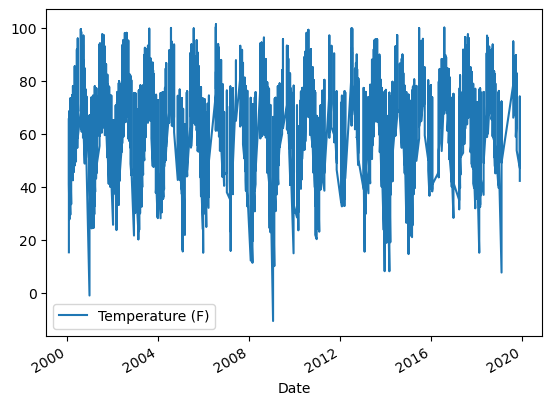

In [524]:
date_temp_df.plot('Date', 'Temperature (F)')

/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/1740114584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_temp_df['Date'] = pd.to_datetime(date_temp_df['Date'])


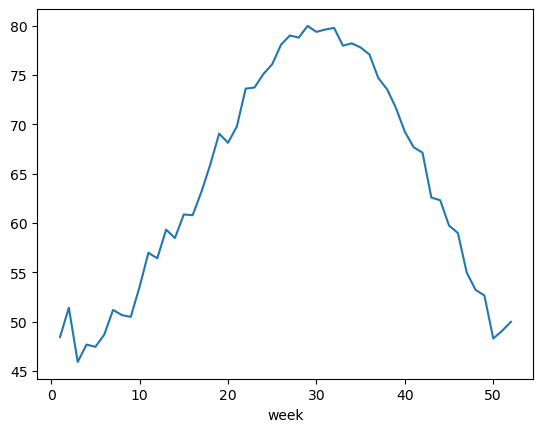

In [525]:
date_temp_df['Date'] = pd.to_datetime(date_temp_df['Date'])
date_temp_df.set_index('Date', inplace=True)
average_date_temp_df = date_temp_df["Temperature (F)"].groupby(by=date_temp_df.index.isocalendar().week).mean().plot()

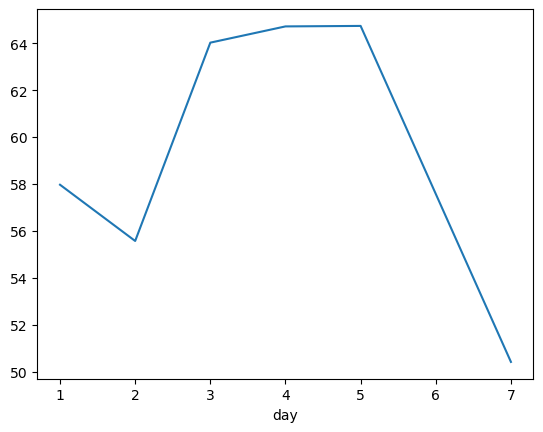

In [526]:
average_date_temp_df = date_temp_df["Temperature (F)"].groupby(by=date_temp_df.index.isocalendar().day).mean().plot()

In [527]:
print(date_rev_df['Revenue'].isnull().sum())

0


In [528]:
date_rev_df.dtypes

Date       datetime64[ns]
Revenue           float64
dtype: object

<Axes: xlabel='Date'>

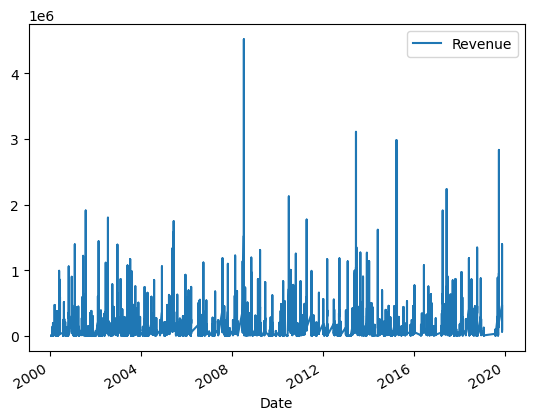

In [529]:
date_rev_df.plot('Date', 'Revenue')

In [530]:
date_rev_df

,Date,Revenue
0,2000-01-26,1804.69
1,2000-01-26,1381.43
2,2000-01-26,2480.11
3,2000-01-26,255.19
4,2000-01-26,5345.24
...,...,...
2830,2019-11-21,648346.54
2831,2019-11-21,66711.18
2832,2019-11-21,1397345.41
2833,2019-11-21,256040.07


In [531]:
date_rev_df_sorted = date_rev_df.sort_values(by='Revenue', ascending=False)
date_rev_df_sorted

# flatten the table 

date_rev_df_sorted

,Date,Revenue
1383,2008-07-16,4.519733e+06
2048,2013-06-20,3.110241e+06
2342,2015-04-01,2.983028e+06
2349,2015-04-09,2.839700e+06
2825,2019-10-02,2.834676e+06
...,...,...
398,2001-11-21,1.720000e+01
500,2002-04-23,1.589000e+01
654,2003-04-09,1.340000e+01
1837,2011-07-15,1.107000e+01


In [532]:
rename_rev_date_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2835 non-null   datetime64[ns]
 1   City                 2835 non-null   object        
 2   Revenue              2835 non-null   object        
 3   Temperature (F)      2835 non-null   float64       
 4   Weather Description  2835 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 110.9+ KB


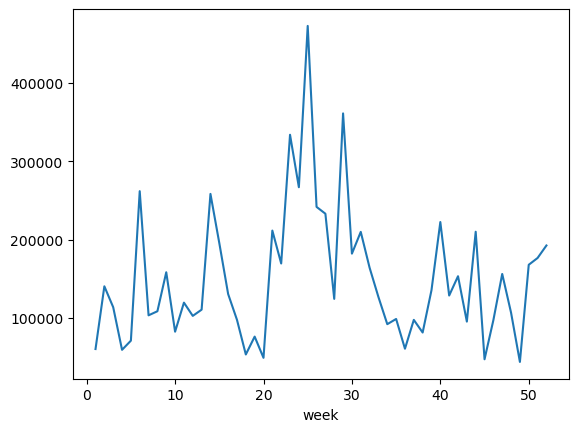

In [533]:
date_rev_df['Date'] = pd.to_datetime(date_rev_df['Date'])
date_rev_df.set_index('Date', inplace=True)
average_date_rev_df = date_rev_df["Revenue"].groupby(by=date_rev_df.index.isocalendar().week).mean().plot()

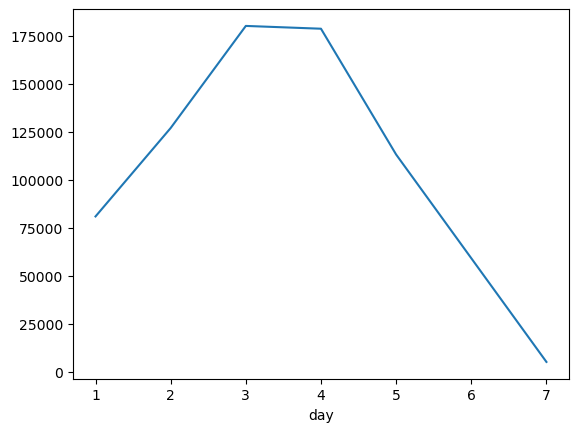

In [534]:
average_date_rev_df = date_rev_df["Revenue"].groupby(by=date_rev_df.index.isocalendar().day).mean().plot()

In [535]:
date_temp_rev_df[['Temperature (F)', 'Revenue']].corr()

,Temperature (F),Revenue
Temperature (F),1.000000,-0.041005
Revenue,-0.041005,1.000000


In [536]:
date_rev_df.reset_index(inplace=True)

In [537]:
clean_date_rev_df = date_rev_df.rename(columns={'Date':'ds', 'Revenue':'y'})
clean_date_rev_df

,ds,y
0,2000-01-26,1804.69
1,2000-01-26,1381.43
2,2000-01-26,2480.11
3,2000-01-26,255.19
4,2000-01-26,5345.24
...,...,...
2830,2019-11-21,648346.54
2831,2019-11-21,66711.18
2832,2019-11-21,1397345.41
2833,2019-11-21,256040.07


In [538]:
model_clean_date_rev = Prophet()


In [539]:
model_clean_date_rev.fit(clean_date_rev_df)


13:24:55 - cmdstanpy - INFO - Chain [1] start processing
python(26872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
13:24:55 - cmdstanpy - INFO - Chain [1] done processing


In [541]:
future_date_rev = model_clean_date_rev.make_future_dataframe(periods=2000, freq='H')
future_date_rev



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
0,2000-01-26 00:00:00
1,2000-02-04 00:00:00
2,2000-02-18 00:00:00
3,2000-02-25 00:00:00
4,2000-03-03 00:00:00
...,...
2400,2020-02-12 04:00:00
2401,2020-02-12 05:00:00
2402,2020-02-12 06:00:00
2403,2020-02-12 07:00:00


In [542]:
forecast_date_rev = model_clean_date_rev.predict(future_date_temp)
forecast_date_rev



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-26 00:00:00,83859.134060,-251809.738994,436599.934268,83859.134060,83859.134060,7931.214874,7931.214874,7931.214874,63097.460350,63097.460350,63097.460350,-55166.245476,-55166.245476,-55166.245476,0.0,0.0,0.0,91790.348935
1,2000-02-04 00:00:00,83970.108781,-282260.386116,427612.733294,83970.108781,83970.108781,-18531.445348,-18531.445348,-18531.445348,13314.379432,13314.379432,13314.379432,-31845.824780,-31845.824780,-31845.824780,0.0,0.0,0.0,65438.663434
2,2000-02-18 00:00:00,84142.736126,-191313.631008,429381.153107,84142.736126,84142.736126,24243.670433,24243.670433,24243.670433,13314.379432,13314.379432,13314.379432,10929.291001,10929.291001,10929.291001,0.0,0.0,0.0,108386.406558
3,2000-02-25 00:00:00,84229.049798,-233782.254233,434096.832979,84229.049798,84229.049798,17147.043966,17147.043966,17147.043966,13314.379432,13314.379432,13314.379432,3832.664534,3832.664534,3832.664534,0.0,0.0,0.0,101376.093764
4,2000-03-03 00:00:00,84315.363470,-269923.477402,406018.767146,84315.363470,84315.363470,-16139.717428,-16139.717428,-16139.717428,13314.379432,13314.379432,13314.379432,-29454.096860,-29454.096860,-29454.096860,0.0,0.0,0.0,68175.646042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,2020-02-12 04:00:00,125792.697757,-140674.235117,517327.709315,125790.213204,125794.459075,63746.415003,63746.415003,63746.415003,67010.491837,67010.491837,67010.491837,-3264.076834,-3264.076834,-3264.076834,0.0,0.0,0.0,189539.112760
2401,2020-02-12 05:00:00,125792.806794,-153344.744603,512796.436021,125790.319711,125794.573115,64831.751240,64831.751240,64831.751240,67956.646450,67956.646450,67956.646450,-3124.895210,-3124.895210,-3124.895210,0.0,0.0,0.0,190624.558034
2402,2020-02-12 06:00:00,125792.915831,-153465.282212,531078.251454,125790.426217,125794.687156,65875.178390,65875.178390,65875.178390,68861.216711,68861.216711,68861.216711,-2986.038321,-2986.038321,-2986.038321,0.0,0.0,0.0,191668.094221
2403,2020-02-12 07:00:00,125793.024868,-137385.683401,528898.417049,125790.532724,125794.801197,66862.012328,66862.012328,66862.012328,69709.523168,69709.523168,69709.523168,-2847.510840,-2847.510840,-2847.510840,0.0,0.0,0.0,192655.037196


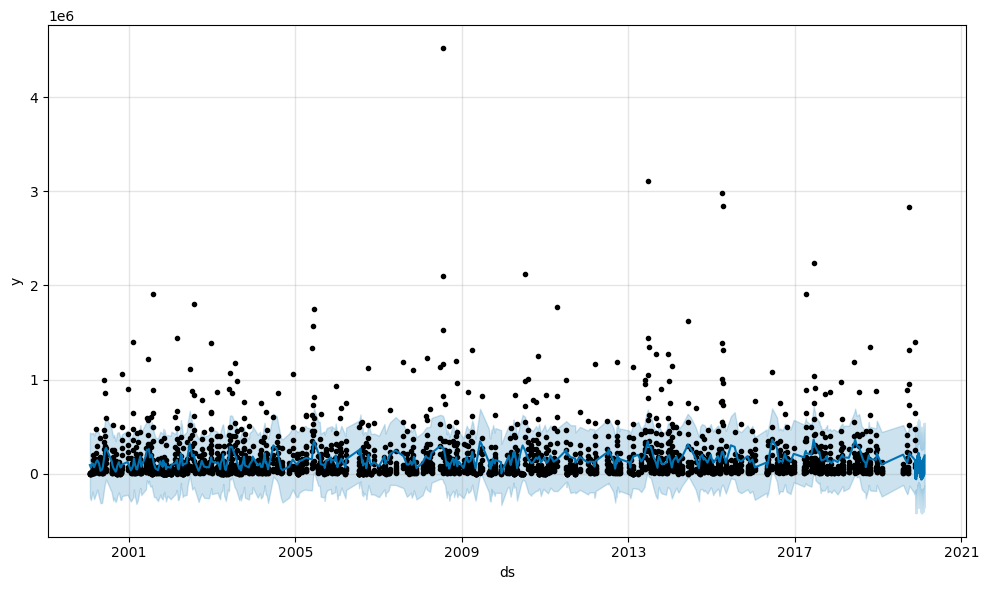

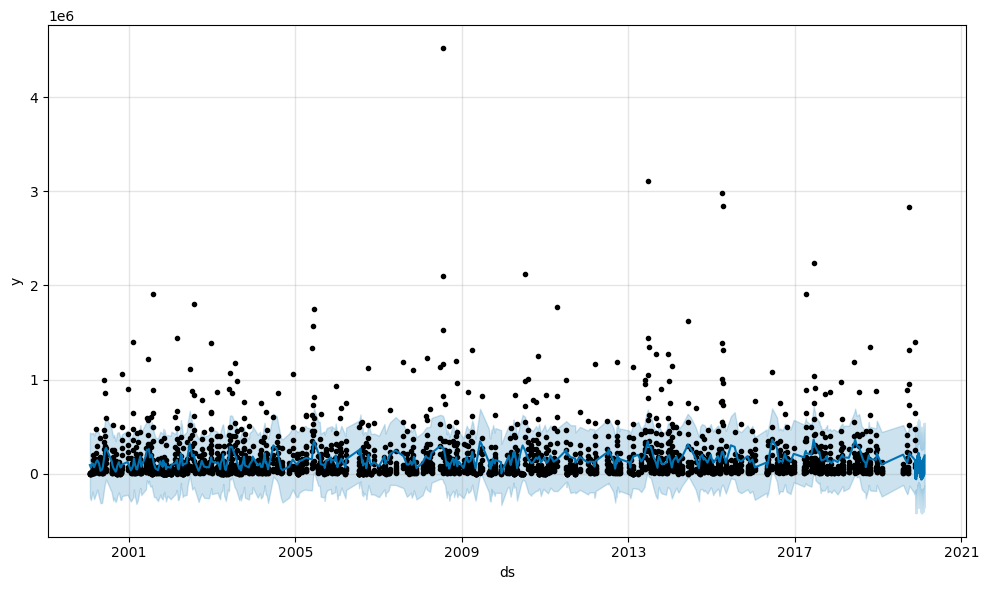

In [543]:
model_clean_date_rev.plot(forecast_date_rev)


In [544]:
forecast_date_rev = forecast_date_rev.set_index('ds')
forecast_date_rev[['yhat', 'yhat_lower', 'yhat_upper']]

,yhat,yhat_lower,yhat_upper
ds,,,
2000-01-26 00:00:00,91790.348935,-251809.738994,436599.934268
2000-02-04 00:00:00,65438.663434,-282260.386116,427612.733294
2000-02-18 00:00:00,108386.406558,-191313.631008,429381.153107
2000-02-25 00:00:00,101376.093764,-233782.254233,434096.832979
2000-03-03 00:00:00,68175.646042,-269923.477402,406018.767146
...,...,...,...
2020-02-12 04:00:00,189539.112760,-140674.235117,517327.709315
2020-02-12 05:00:00,190624.558034,-153344.744603,512796.436021
2020-02-12 06:00:00,191668.094221,-153465.282212,531078.251454


<Axes: xlabel='ds'>

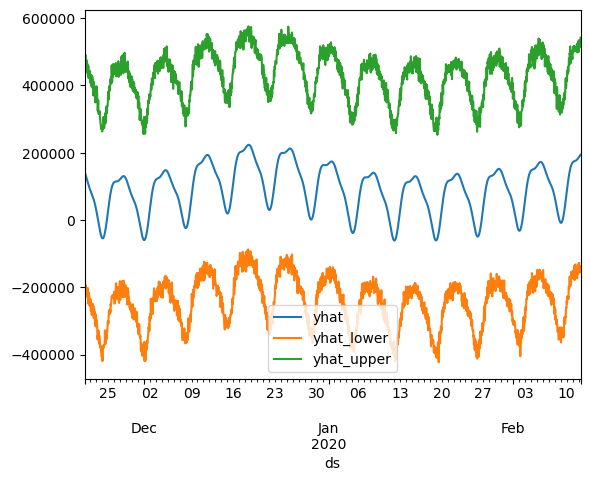

In [545]:
forecast_date_rev[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:,:].plot()



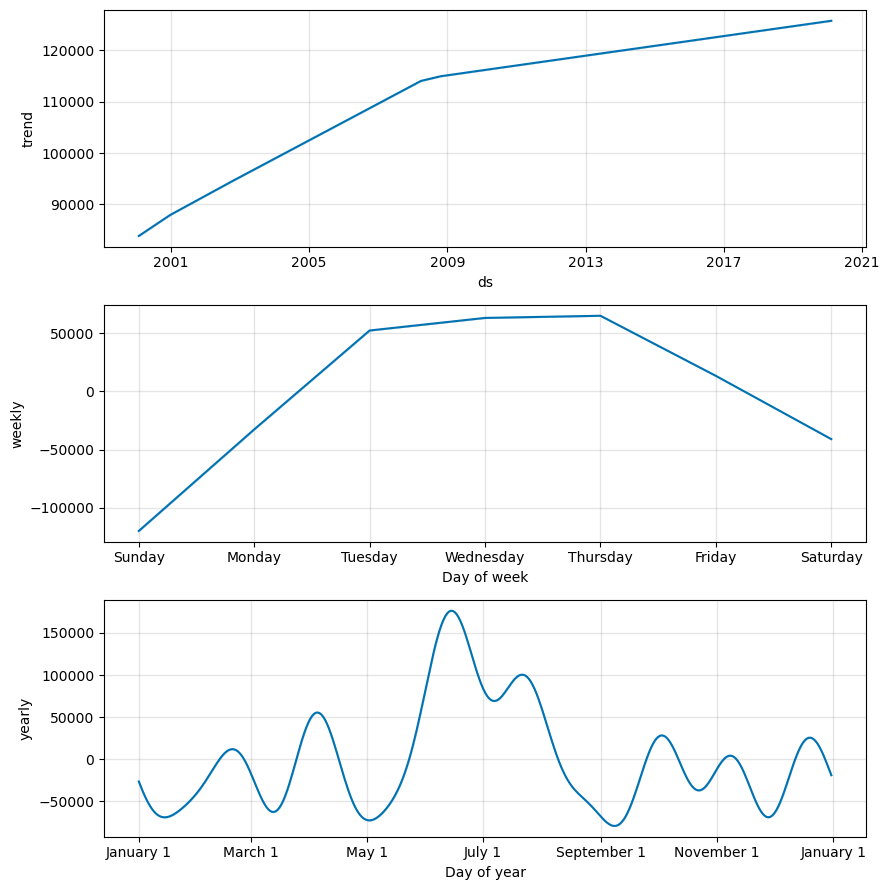

In [546]:
forecast_date_rev = forecast_date_rev.reset_index()
fig_forecast_date_rev = model_clean_date_rev.plot_components(forecast_date_rev)

### We assumed the weekend would be the highest moviegoing period, but we were surprised to learn through our analysis that Thursday was instead the highest in terms of viewership and sales

### On average, theatres generate the most revenue around late June and on Thursdays.

In [547]:
date_temp_rev_corr_matrix = date_temp_rev_df.corr()
date_temp_rev_corr_matrix

,Temperature (F),Revenue
Temperature (F),1.000000,-0.041005
Revenue,-0.041005,1.000000


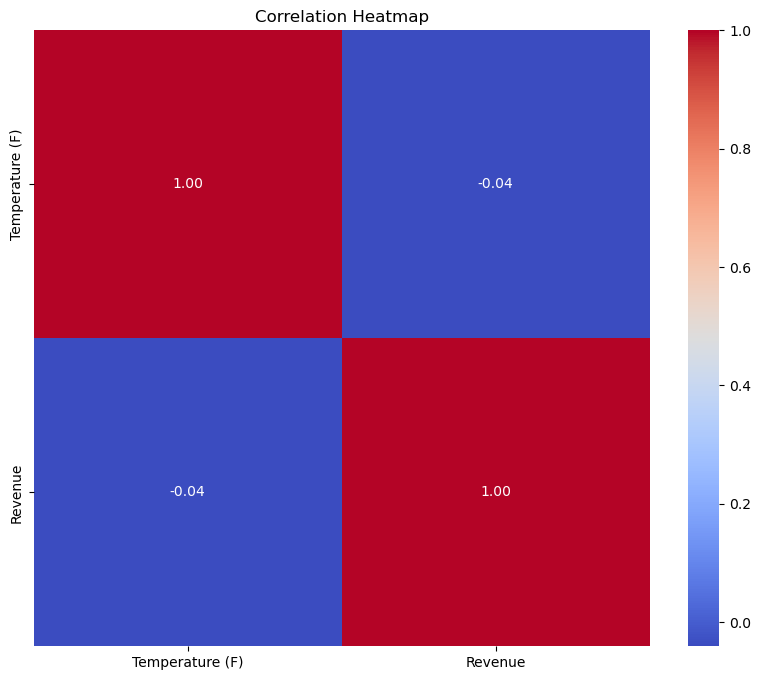

In [548]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(date_temp_rev_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

### There is very little correlation between Temperature and Revenue, due to the fact that there are some cities that experience consistent weather throughout a given year. Revenue appears to be dependent on other variables such as school break and other summer based holidays as indicated by our graphs showing the greatest uptick in sales and viewership being in Late June

In [ ]:
#create a dataframe of the top ten highest grossing films between 2000-2020
highest_grossing_movies_df = merged_movies_weather.sort_values(by='Domestic Revenue ($)', ascending=False)
highest_grossing_movies_df.head(20)

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,Steve Carell,Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,Steve Carell,Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,Jackie Chan,Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,Vin Diesel,Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,Mike Myers,Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [ ]:
#store the top ten grossing movies in a dataframe
top_twenty_movies_df = highest_grossing_movies_df.head(20)
top_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,Steve Carell,Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,Steve Carell,Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,Jackie Chan,Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,Vin Diesel,Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,Mike Myers,Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [ ]:
top_twenty_movies_df = top_twenty_movies_df.dropna()
top_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,Steve Carell,Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,Steve Carell,Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,Jackie Chan,Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,Vin Diesel,Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,Mike Myers,Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [ ]:
#create a dataframe of the lowest grossing films between 2000-2020
lowest_grossing_movies_df = merged_movies_weather.sort_values(by='Domestic Revenue ($)', ascending=True)
lowest_grossing_movies_df.head(20)

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
294,Shade,25032,Crime,Joe Nicolo,Carl Mazzocone Sr.,R,2003-04-09,$13.40,$94.79,$72.56,...,37.065652,76.022917,49.618750,overcast clouds,sky is clear,sky is clear,scattered clouds,overcast clouds,sky is clear,overcast clouds
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,$11.07,$78.30,$59.94,...,73.241250,88.893333,60.647917,broken clouds,light rain,overcast clouds,overcast clouds,sky is clear,sky is clear,overcast clouds
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,$15.89,$112.36,$86.00,...,46.684615,77.042500,45.509167,overcast clouds,broken clouds,sky is clear,scattered clouds,mist,scattered clouds,light rain
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,$19.73,$139.55,$106.82,...,77.016250,101.378333,61.513333,scattered clouds,scattered clouds,sky is clear,scattered clouds,overcast clouds,few clouds,overcast clouds
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
192,Leaves of Grass,70066,Comedy,Edward Norton,Keri Russell,R,2009-09-17,$27.44,$194.03,$148.53,...,60.302500,86.283750,61.151667,few clouds,few clouds,sky is clear,light rain,light rain,few clouds,overcast clouds
122,Eye See You,79161,Crime,Sylvester Stallone,Charles S. Dutton,R,2002-01-04,$31.94,$225.85,$172.88,...,31.957083,53.573333,46.543750,sky is clear,sky is clear,sky is clear,few clouds,few clouds,overcast clouds,scattered clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
418,Trust,120016,Crime,Clive Owen,Catherine Keener,R,2010-04-01,$48.42,$342.41,$262.10,...,55.727083,65.100417,44.845417,broken clouds,broken clouds,sky is clear,sky is clear,few clouds,scattered clouds,broken clouds
66,Bubble,145626,Crime,Debbie Doebereiner,Omar Cowan,R,2005-01-27,$58.65,$414.78,$317.50,...,15.715000,57.668333,48.070417,light snow,broken clouds,light rain,sky is clear,overcast clouds,light rain,light rain


In [ ]:
#save lowest_grossing_movies_df to a dataframe
bottom_twenty_movies_df = lowest_grossing_movies_df.head(20)
bottom_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
294,Shade,25032,Crime,Joe Nicolo,Carl Mazzocone Sr.,R,2003-04-09,$13.40,$94.79,$72.56,...,37.065652,76.022917,49.618750,overcast clouds,sky is clear,sky is clear,scattered clouds,overcast clouds,sky is clear,overcast clouds
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,$11.07,$78.30,$59.94,...,73.241250,88.893333,60.647917,broken clouds,light rain,overcast clouds,overcast clouds,sky is clear,sky is clear,overcast clouds
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,$15.89,$112.36,$86.00,...,46.684615,77.042500,45.509167,overcast clouds,broken clouds,sky is clear,scattered clouds,mist,scattered clouds,light rain
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,$19.73,$139.55,$106.82,...,77.016250,101.378333,61.513333,scattered clouds,scattered clouds,sky is clear,scattered clouds,overcast clouds,few clouds,overcast clouds
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
192,Leaves of Grass,70066,Comedy,Edward Norton,Keri Russell,R,2009-09-17,$27.44,$194.03,$148.53,...,60.302500,86.283750,61.151667,few clouds,few clouds,sky is clear,light rain,light rain,few clouds,overcast clouds
122,Eye See You,79161,Crime,Sylvester Stallone,Charles S. Dutton,R,2002-01-04,$31.94,$225.85,$172.88,...,31.957083,53.573333,46.543750,sky is clear,sky is clear,sky is clear,few clouds,few clouds,overcast clouds,scattered clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
418,Trust,120016,Crime,Clive Owen,Catherine Keener,R,2010-04-01,$48.42,$342.41,$262.10,...,55.727083,65.100417,44.845417,broken clouds,broken clouds,sky is clear,sky is clear,few clouds,scattered clouds,broken clouds
66,Bubble,145626,Crime,Debbie Doebereiner,Omar Cowan,R,2005-01-27,$58.65,$414.78,$317.50,...,15.715000,57.668333,48.070417,light snow,broken clouds,light rain,sky is clear,overcast clouds,light rain,light rain


In [ ]:
bottom_twenty_movies_df = bottom_twenty_movies_df.dropna()
bottom_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
294,Shade,25032,Crime,Joe Nicolo,Carl Mazzocone Sr.,R,2003-04-09,$13.40,$94.79,$72.56,...,37.065652,76.022917,49.618750,overcast clouds,sky is clear,sky is clear,scattered clouds,overcast clouds,sky is clear,overcast clouds
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,$11.07,$78.30,$59.94,...,73.241250,88.893333,60.647917,broken clouds,light rain,overcast clouds,overcast clouds,sky is clear,sky is clear,overcast clouds
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,$15.89,$112.36,$86.00,...,46.684615,77.042500,45.509167,overcast clouds,broken clouds,sky is clear,scattered clouds,mist,scattered clouds,light rain
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,$19.73,$139.55,$106.82,...,77.016250,101.378333,61.513333,scattered clouds,scattered clouds,sky is clear,scattered clouds,overcast clouds,few clouds,overcast clouds
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
192,Leaves of Grass,70066,Comedy,Edward Norton,Keri Russell,R,2009-09-17,$27.44,$194.03,$148.53,...,60.302500,86.283750,61.151667,few clouds,few clouds,sky is clear,light rain,light rain,few clouds,overcast clouds
122,Eye See You,79161,Crime,Sylvester Stallone,Charles S. Dutton,R,2002-01-04,$31.94,$225.85,$172.88,...,31.957083,53.573333,46.543750,sky is clear,sky is clear,sky is clear,few clouds,few clouds,overcast clouds,scattered clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
418,Trust,120016,Crime,Clive Owen,Catherine Keener,R,2010-04-01,$48.42,$342.41,$262.10,...,55.727083,65.100417,44.845417,broken clouds,broken clouds,sky is clear,sky is clear,few clouds,scattered clouds,broken clouds
66,Bubble,145626,Crime,Debbie Doebereiner,Omar Cowan,R,2005-01-27,$58.65,$414.78,$317.50,...,15.715000,57.668333,48.070417,light snow,broken clouds,light rain,sky is clear,overcast clouds,light rain,light rain


In [ ]:
# clean_movies_cities_df = rename_clean_movies_cities_df[['Date', 'Miami Revenue ($)', 'Chicago Revenue ($)', 
#                    'Houston Revenue ($)', 'Phoenix Revenue ($)', 
#                    'Los Angeles Revenue ($)', 'New York Revenue ($)', 'Seattle Revenue ($)']].copy()

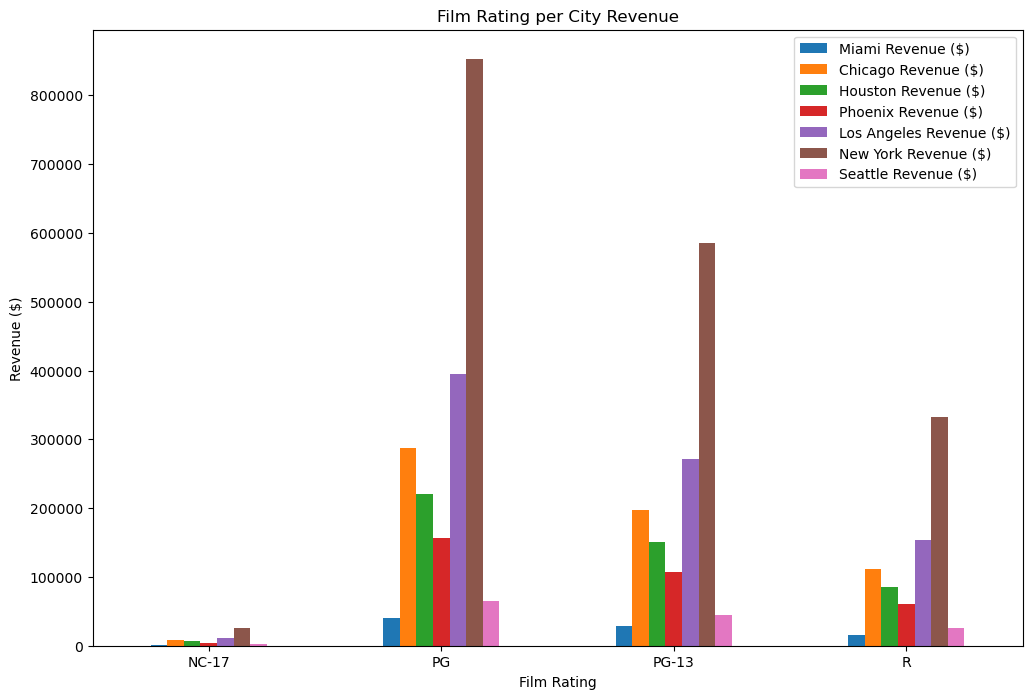

In [ ]:
# Convert revenue columns to numeric values
revenue_columns = ['Miami Revenue ($)', 'Chicago Revenue ($)', 'Houston Revenue ($)', 
                'Phoenix Revenue ($)', 'Los Angeles Revenue ($)', 'New York Revenue ($)', 'Seattle Revenue ($)']
for col in ['Miami Revenue ($)', 'Chicago Revenue ($)', 'Houston Revenue ($)', 'Phoenix Revenue ($)', 'Los Angeles Revenue ($)', 
            'New York Revenue ($)', 'Seattle Revenue ($)']:
    merged_movies_weather.loc[:, col] = merged_movies_weather[col].replace('[$,]', '', regex=True).astype(float)

# Group by Film Rating and calculate the sum of revenues for each rating
grouped_revenue_by_rating = merged_movies_weather.groupby('Film Rating')[revenue_columns].mean()

# Display the result
grouped_revenue_by_rating
# Plot the Film Rating per city revenue
grouped_revenue_by_rating.plot(kind='bar', figsize=(12, 8))

# Set the title and labels
plt.title('Film Rating per City Revenue')
plt.xlabel('Film Rating')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=0)

# Display the plot
plt.show()


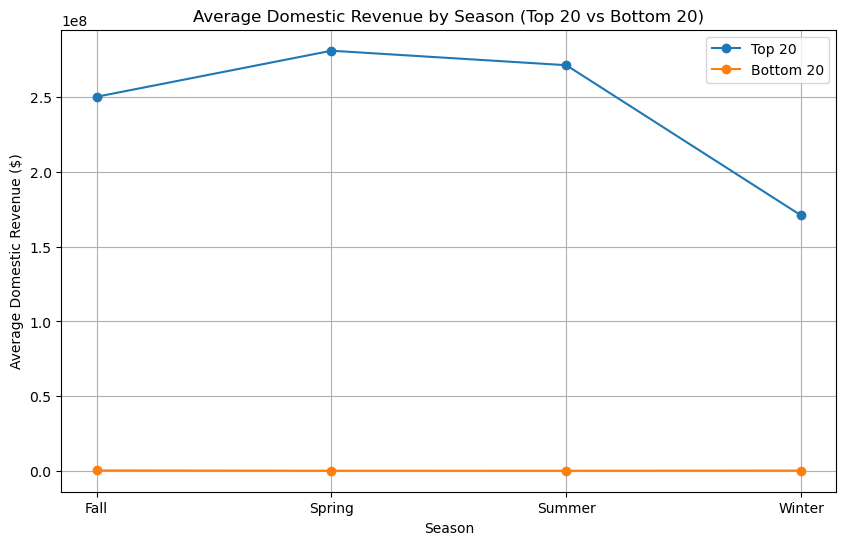

In [ ]:
# Assuming you have top_twenty_movies_df and bottom_twenty_movies_df with 'Release Date' and 'Domestic Revenue ($)' columns

# 1. Function to determine the season based on the month (same as before)
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# 2. Function to process a DataFrame and get seasonal revenue
def get_seasonal_revenue(df):
    df['Release Date'] = pd.to_datetime(df['Release Date'])  # Convert to datetime
    df['Season'] = df['Release Date'].apply(get_season)  # Add 'Season' column
    seasonal_revenue = df.groupby('Season')['Domestic Revenue ($)'].mean().reset_index()  # Calculate average revenue
    return seasonal_revenue

# 3. Get seasonal revenue for top and bottom 20 movies
top_seasonal_revenue = get_seasonal_revenue(top_twenty_movies_df.copy())  # Use copy to avoid modifying original DataFrame
bottom_seasonal_revenue = get_seasonal_revenue(bottom_twenty_movies_df.copy())

# 4. Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(top_seasonal_revenue['Season'], top_seasonal_revenue['Domestic Revenue ($)'], marker='o', label='Top 20')
plt.plot(bottom_seasonal_revenue['Season'], bottom_seasonal_revenue['Domestic Revenue ($)'], marker='o', label='Bottom 20')
plt.xlabel('Season')
plt.ylabel('Average Domestic Revenue ($)')
plt.title('Average Domestic Revenue by Season (Top 20 vs Bottom 20)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Add more information to top and bottom twenty charts, such as genre, rating, and runtime, to see what is happening and what this data is telling us

<Axes: xlabel='Season'>

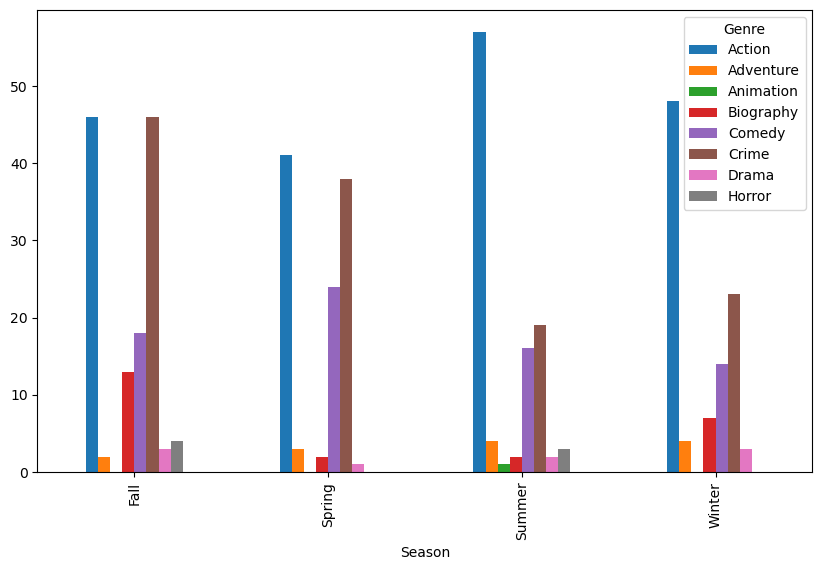

In [ ]:
import pandas as pd

# Assuming 'Release Date' column is in datetime format:
merged_movies_weather['Release Date'] = pd.to_datetime(merged_movies_weather['Release Date'])
# If it's not, you need to convert it to datetime format first.

# Function to extract season from date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a 'Season' column
merged_movies_weather['Season'] = merged_movies_weather['Release Date'].apply(get_season)

# Group by 'Season' and 'Genre' and count occurrences
genre_frequency_by_season = merged_movies_weather.groupby(['Season', 'Genre'])['Genre'].count().unstack()

# Plot the results
genre_frequency_by_season.plot(kind='bar', figsize=(10, 6))

In [ ]:
import pandas as pd

# Assuming 'Release Date' column is in datetime format:
merged_movies_weather['Release Date'] = pd.to_datetime(merged_movies_weather['Release Date'])
# If it's not, you need to convert it to datetime format first.

# Function to extract season from date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a 'Season' column
merged_movies_weather['Season'] = merged_movies_weather['Release Date'].apply(get_season)

# Group by 'Season' and get the maximum 'Domestic Revenue ($)'
highest_revenue_by_season = merged_movies_weather.groupby('Season')['Domestic Revenue ($)'].max()
highest_revenue_by_season



Season
Fall      335451311
Spring    353007020
Summer    535234033
Winter    204417855
Name: Domestic Revenue ($), dtype: int64

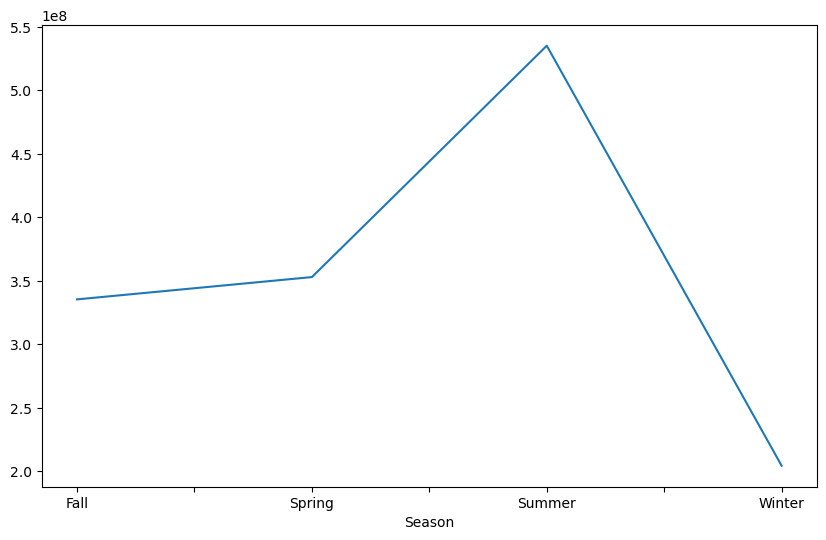

In [ ]:
# Plot the results
highest_revenue_by_season.plot(kind='line', figsize=(10, 6))
x_labels = ['Spring', 'Summer', 'Fall', 'Winter']

y_labels = [f'${value:,.0f}' for value in highest_revenue_by_season]

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(merged_movies_weather['Genre'], merged_movies_weather['Season'])

# Perform the chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of freedom: {dof}")

# Interpret the results
alpha = 0.05  # Significance level
if p_val < alpha:
    print("There is a statistically significant association between genre and season.")
else:
    print("There is no statistically significant association between genre and season.")



Chi-squared statistic: 40.64482538485163
P-value: 0.006202071201625172
Degrees of freedom: 21
There is a statistically significant association between genre and season.


In [ ]:
#calulate the frequency of each genre in cleaned_movies_citiies_df
genre_counts = merged_movies_weather['Genre'].value_counts()
print(genre_counts)

Genre
Action       192
Crime        126
Comedy        72
Biography     24
Adventure     13
Drama          9
Horror         7
Animation      1
Name: count, dtype: int64


In [ ]:
#save genre counts in a dataframe
genre_counts_df = pd.DataFrame(genre_counts)
genre_counts_df

,count
Genre,
Action,192
Crime,126
Comedy,72
Biography,24
Adventure,13
Drama,9
Horror,7
Animation,1


In [ ]:
# correlate leading actor and domestic revenue in 'merge_movies_weather_df'
actor_revenue_corr = top_twenty_movies_df['Leading Actor'].str.get_dummies(sep=', ').corrwith(top_twenty_movies_df['Domestic Revenue ($)'])
actor_revenue_corr_df = pd.DataFrame(actor_revenue_corr)
actor_revenue_corr_df

,0
Anthony Hopkins,-0.214145
Brad Pitt,-0.160677
Channing Tatum,-0.147128
Christian Bale,0.442688
Daniel Craig,-0.213463
George Clooney,-0.168024
Jackie Chan,-0.060435
Joaquin Phoenix,0.214628
Leonardo DiCaprio,-0.215346
Mike Myers,-0.092793


In [ ]:
# For top_twenty_movies_df, split the 'Actors' column into a list of individual actors
# Ensure the 'Leading Actor' column contains strings before using .str
top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')
top_twenty_movies_df

/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/1352114251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')


,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,[Christian Bale],Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,[Steve Carell],Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,[Vin Diesel],Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,[Sandra Bullock],Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,[Joaquin Phoenix],Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,[Steve Carell],Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,[Steve Carell],Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,[Jackie Chan],Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,[Vin Diesel],Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,[Mike Myers],Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [ ]:
# Create a new DataFrame with one-hot encoded actors
actors_df = pd.get_dummies(top_twenty_movies_df['Leading Actor'].apply(pd.Series).stack()).groupby(level=0).sum()

In [ ]:
# Reset index of actors_df to match clean_movies_cities_df
actors_df = actors_df.reset_index(drop=True)

In [ ]:
# 2. Concatenate with revenue
# Concatenate the one-hot encoded actors with the revenue column
correlation_df = pd.concat([top_twenty_movies_df['Domestic Revenue ($)'], actors_df], axis=1)

In [ ]:
# 3. Calculate correlation
# Calculate the correlation between each actor and revenue
actor_correlations = correlation_df.corr()['Domestic Revenue ($)'].drop('Domestic Revenue ($)')

In [ ]:
for actor, correlation in actor_revenue_corr.items():
    print(f"Correlation between {actor} and Domestic Revenue: {correlation:.2f}")


Correlation between Anthony Hopkins and Domestic Revenue: -0.21
Correlation between Brad Pitt and Domestic Revenue: -0.16
Correlation between Channing Tatum and Domestic Revenue: -0.15
Correlation between Christian Bale and Domestic Revenue: 0.44
Correlation between Daniel Craig and Domestic Revenue: -0.21
Correlation between George Clooney and Domestic Revenue: -0.17
Correlation between Jackie Chan and Domestic Revenue: -0.06
Correlation between Joaquin Phoenix and Domestic Revenue: 0.21
Correlation between Leonardo DiCaprio and Domestic Revenue: -0.22
Correlation between Mike Myers and Domestic Revenue: -0.09
Correlation between Renée Zellweger and Domestic Revenue: -0.20
Correlation between Sandra Bullock and Domestic Revenue: 0.22
Correlation between Steve Carell and Domestic Revenue: 0.21
Correlation between Vin Diesel and Domestic Revenue: 0.06


In [ ]:
# For top_twenty_movies_df, split the 'Actors' column into a list of individual actors
# Ensure the 'Leading Actor' column contains strings before using .str
top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')

# Create a new DataFrame with one-hot encoded actors
actors_df = pd.get_dummies(top_twenty_movies_df['Leading Actor'].apply(pd.Series).stack()).groupby(level=0).sum()

# Reset index of actors_df to match clean_movies_cities_df
actors_df = actors_df.reset_index(drop=True)

# 2. Concatenate with revenue
# Concatenate the one-hot encoded actors with the revenue column
correlation_df = pd.concat([top_twenty_movies_df['Domestic Revenue ($)'], actors_df], axis=1)


# 3. Calculate correlation
# Calculate the correlation between each actor and revenue
actor_correlations = correlation_df.corr()['Domestic Revenue ($)'].drop('Domestic Revenue ($)')



/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/2575946228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')


In [ ]:
actor_revenue_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, Anthony Hopkins to Vin Diesel
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14 non-null     float64
dtypes: float64(1)
memory usage: 224.0+ bytes


In [ ]:
# Convert the Series to a DataFrame for easier manipulation
actor_correlations_df = pd.DataFrame({'Correlation': actor_revenue_corr})

# Sort the DataFrame by 'Correlation' in descending order and get the top 20
top_20_correlations_df = actor_correlations_df.sort_values(by=['Correlation'], ascending=False).head(20) # Change this line

#save the top 20 correlations to a dataframe
top_20_correlations_df = pd.DataFrame(top_20_correlations_df) # Change this line

# Now top_20_correlations_df contains the top 20 correlations
#print(top_20_correlations_df)


In [ ]:
actor_correlations_df.count()

Correlation    14
dtype: int64

In [ ]:
#review top_20_correlations dataframe
actor_correlations_df

,Correlation
Anthony Hopkins,-0.214145
Brad Pitt,-0.160677
Channing Tatum,-0.147128
Christian Bale,0.442688
Daniel Craig,-0.213463
George Clooney,-0.168024
Jackie Chan,-0.060435
Joaquin Phoenix,0.214628
Leonardo DiCaprio,-0.215346
Mike Myers,-0.092793


/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/2399402690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y=top_20_correlations_df.index, data=top_20_correlations_df, palette='coolwarm')


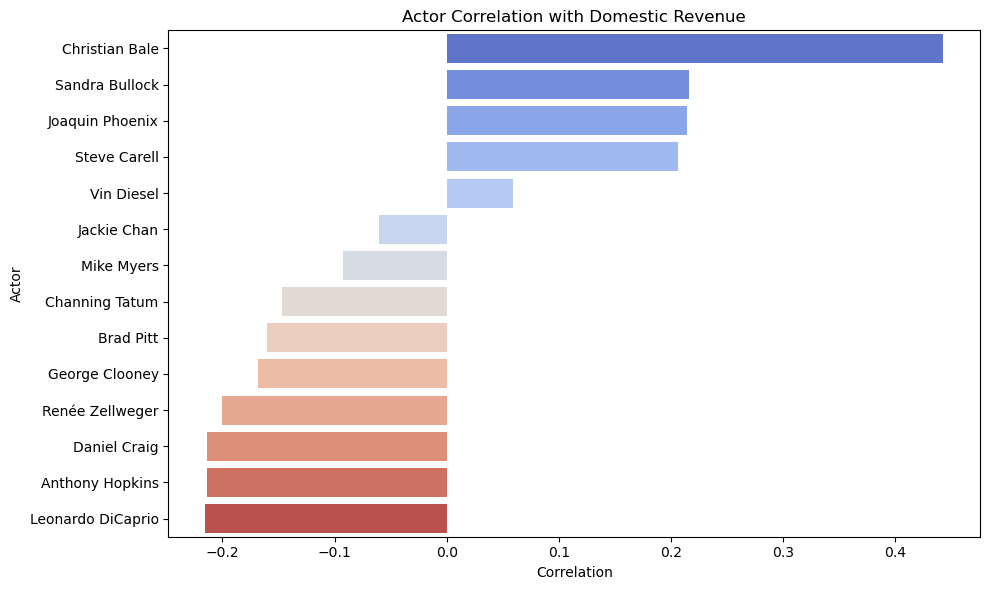

In [ ]:

# Create a new DataFrame from actor_revenue_corr, avoiding overwriting the original Series
top_20_correlations_df = pd.DataFrame({'Correlation': actor_revenue_corr}) 

# Sort the DataFrame by 'Correlation' in descending order
top_20_correlations_df = top_20_correlations_df.sort_values(by=['Correlation'], ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y=top_20_correlations_df.index, data=top_20_correlations_df, palette='coolwarm')

plt.title('Actor Correlation with Domestic Revenue')
plt.xlabel('Correlation')
plt.ylabel('Actor')
plt.tight_layout()
plt.show()

In [ ]:
merge_movies_weather_df = merged_movies_weather.dropna()
merge_movies_weather_df.head()

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description,Season
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,21.58,152.58,116.8,...,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear,Summer
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,9845.14,69624.34,53295.13,...,58.111667,46.157083,haze,light rain,overcast clouds,few clouds,overcast clouds,scattered clouds,broken clouds,Spring
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,51298.18,362778.2,277694.7,...,91.475833,64.324167,broken clouds,broken clouds,sky is clear,thunderstorm,mist,few clouds,sky is clear,Summer
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,32742.17,231551.03,177244.65,...,72.545833,38.504583,light rain and snow,broken clouds,sky is clear,scattered clouds,overcast clouds,few clouds,broken clouds,Spring
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,6572.08,46477.4,35576.91,...,62.507917,37.777500,scattered clouds,few clouds,sky is clear,scattered clouds,sky is clear,sky is clear,light rain,Fall


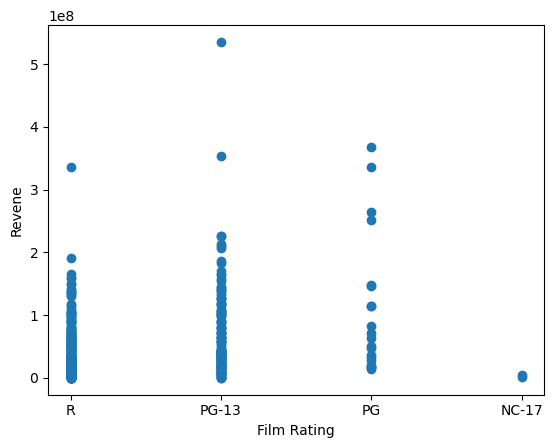

In [ ]:
#Determine if Domestic Revenue and Genres are correlated.

plt.scatter(merge_movies_weather_df.iloc[:,5],merge_movies_weather_df.iloc[:,1])
plt.xlabel('Film Rating')
plt.ylabel('Revene')
plt.show()

In [ ]:
movie_title = 'Unleashed'.lower()
movie_data = merged_movies_weather[merged_movies_weather['Movie Title'].str.lower() == movie_title]


In [ ]:
print(movie_data)


    Movie Title  Domestic Revenue ($)   Genre Leading Actor Supporting Actor  \
424   Unleashed              24537621  Action        Jet Li      Bob Hoskins   

    Film Rating Release Date Miami Revenue ($) Chicago Revenue ($)  \
424           R   2005-02-02           9892.48            69959.12   

    Houston Revenue ($)  ... Phoenix Temperature Seattle Temperature  \
424            53551.39  ...            54.95625           49.368333   

    Chicago Weather Description Houston Weather Description  \
424             overcast clouds               moderate rain   

     Los Angeles Weather Description  Miami Weather Description  \
424                     sky is clear           scattered clouds   

     New York Weather Description  Phoenix Weather Description  \
424                  sky is clear             scattered clouds   

     Seattle Weather Description  Season  
424             scattered clouds  Winter  

[1 rows x 29 columns]


/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/649742107.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  revenue = movie_data[revenue_column].fillna('0').astype(str).str.replace(',', '').str.replace('$', '')
/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/649742107.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  revenue = movie_data[revenue_column].fillna('0').astype(str).str.replace(',', '').str.replace('$', '')
/var/folders/5h/clwzvcpx0w33zvszv119nd7m0000gn/T/ipykernel_95802/649742107.py:42: FutureWarning: D

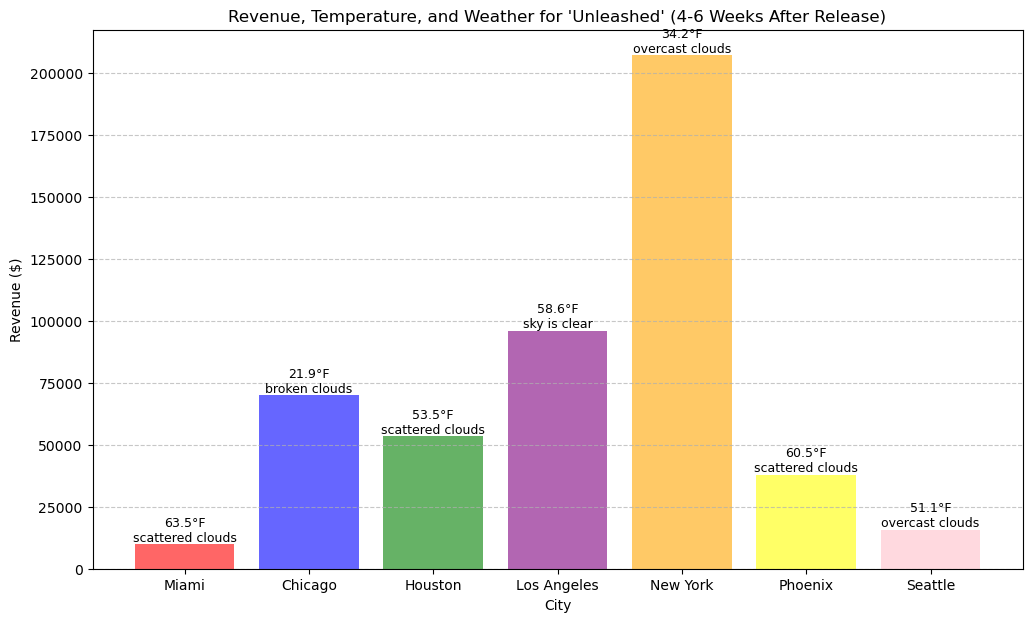

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame (Replace with your actual `merged_movies_weather`)
# merged_movies_weather = pd.read_csv("your_data.csv")

# Movie title
movie_title = 'Unleashed'  # Replace with the actual title

# Filter for the movie data
movie_data = merged_movies_weather[merged_movies_weather['Movie Title'] == movie_title]

# Check if movie exists in the dataset
if movie_data.empty:
    raise ValueError(f"No data found for the movie title '{movie_title}'.")

# Extract the release date and convert it to datetime
release_date = pd.to_datetime(movie_data['Release Date'].values[0])

# Calculate the target date range (4-6 weeks after release date)
start_date = release_date + pd.Timedelta(weeks=4)
end_date = release_date + pd.Timedelta(weeks=6)

# Filter the merged DataFrame for rows within the target date range
date_filtered_data = merged_movies_weather[
    (merged_movies_weather['Release Date'] >= start_date) &
    (merged_movies_weather['Release Date'] <= end_date)
]

# List of cities to analyze
cities = ['Miami', 'Chicago', 'Houston', 'Los Angeles', 'New York', 'Phoenix', 'Seattle']

# Extract revenue and weather data
revenues = []
temperatures = []
weather_descriptions = []

for city in cities:
    # Extract revenue and handle missing or invalid values
    revenue_column = f'{city} Revenue ($)'
    if revenue_column in movie_data.columns:
        revenue = movie_data[revenue_column].fillna('0').astype(str).str.replace(',', '').str.replace('$', '')
        revenue = float(revenue.iloc[0]) if not revenue.empty else 0
    else:
        revenue = 0
    revenues.append(revenue)
    
    # Extract average temperature for the city
    temperature_column = f'{city} Temperature'
    if temperature_column in date_filtered_data.columns:
        temperature = date_filtered_data[temperature_column].mean()
    else:
        temperature = None
    temperatures.append(temperature)
    
    # Extract weather description for the city
    weather_column = f'{city} Weather Description'
    if weather_column in date_filtered_data.columns:
        weather = date_filtered_data[weather_column].iloc[0] if not date_filtered_data[weather_column].empty else "N/A"
    else:
        weather = "N/A"
    weather_descriptions.append(weather)

# Create a bar plot with revenue data
plt.figure(figsize=(12, 7))
bars = plt.bar(cities, revenues, color=['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink'], alpha=0.6)

# Add temperature and weather description labels on top of each bar
for bar, temp, weather in zip(bars, temperatures, weather_descriptions):
    label = f"{temp:.1f}°F\n{weather}" if temp is not None else weather
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label,
             ha='center', va='bottom', color='black', fontsize=9)

# Add titles and labels
plt.xlabel('City')
plt.ylabel('Revenue ($)')
plt.title(f"Revenue, Temperature, and Weather for '{movie_title}' (4-6 Weeks After Release)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


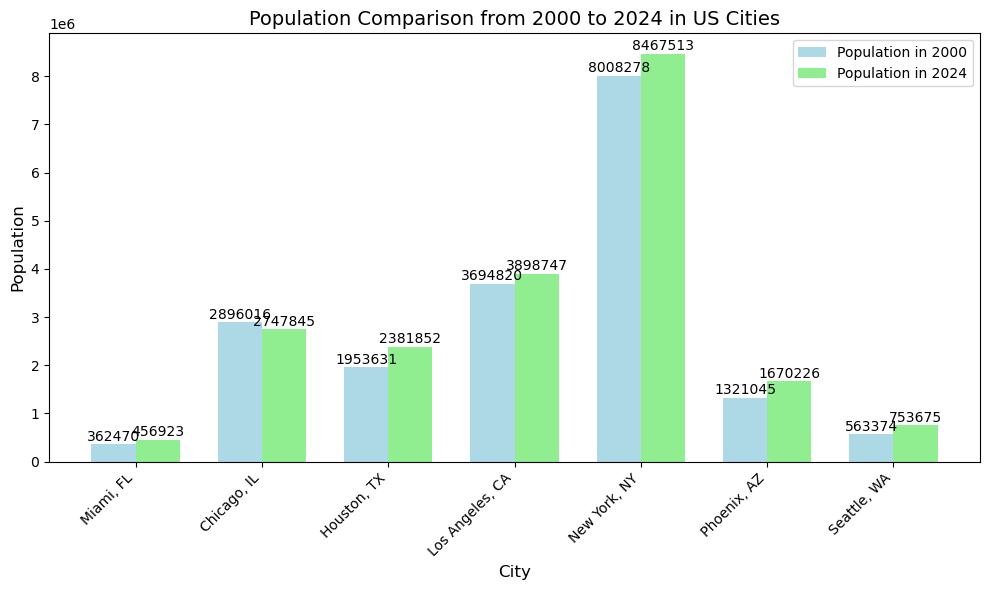

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for the cities and their populations in 2000 and 2024
population_dict_comparison = {
    "City": ["Miami, FL", "Chicago, IL", "Houston, TX", "Los Angeles, CA", "New York, NY", "Phoenix, AZ", "Seattle, WA"],
    "Population_2000": [362470, 2896016, 1953631, 3694820, 8008278, 1321045, 563374],
    "Population_2024": [456923, 2747845, 2381852, 3898747, 8467513, 1670226, 753675]
}

# Create a DataFrame from the dictionary
population_df_comparison = pd.DataFrame(population_dict_comparison)

# Calculate the population increase
population_df_comparison['Increase'] = population_df_comparison['Population_2024'] - population_df_comparison['Population_2000']

# Create a figure for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the population comparison (2000 vs 2024)
width = 0.35  # Width of the bars for the 2000 and 2024 populations
x = range(len(population_df_comparison))

# Plot 2000 and 2024 population bars
bars_2000 = ax.bar(x, population_df_comparison['Population_2000'], width, label='Population in 2000', color='lightblue')
bars_2024 = ax.bar([p + width for p in x], population_df_comparison['Population_2024'], width, label='Population in 2024', color='lightgreen')

# Adding titles and labels
ax.set_title('Population Comparison from 2000 to 2024 in US Cities', fontsize=14)
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Population', fontsize=12)
ax.set_xticks([p + width / 2 for p in x])  # Center the ticks between the bars
ax.set_xticklabels(population_df_comparison['City'], rotation=45, ha="right")

# Add the population numbers on top of each bar
for bar in bars_2000:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10000, f'{int(height)}', ha='center', va='bottom', fontsize=10)

for bar in bars_2024:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10000, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Add a legend
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()
